In [2]:
#importing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

In [3]:
# loading the dataset
df = pd.read_csv("California_Fire_Incidents.csv")
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('-', '')

In [4]:
df.head()  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcresBurned           1633 non-null   float64
 1   Active                1636 non-null   bool   
 2   AdminUnit             1636 non-null   object 
 3   AirTankers            28 non-null     float64
 4   ArchiveYear           1636 non-null   int64  
 5   CalFireIncident       1636 non-null   bool   
 6   CanonicalUrl          1636 non-null   object 
 7   ConditionStatement    284 non-null    object 
 8   ControlStatement      105 non-null    object 
 9   Counties              1636 non-null   object 
 10  CountyIds             1636 non-null   object 
 11  CrewsInvolved         171 non-null    float64
 12  Dozers                123 non-null    float64
 13  Engines               191 non-null    float64
 14  Extinguished          1577 non-null   object 
 15  Fatalities           

In [5]:
df['Started'] = pd.to_datetime(df['Started'], errors='coerce')


In [6]:
# Drop missing date or burned area
df = df.dropna(subset=['Started', 'AcresBurned'])

In [7]:
# Fill missing acres and remove zero entries
df['AcresBurned'] = df['AcresBurned'].fillna(0)
df = df[df['AcresBurned'] > 0]


In [8]:
print(df.columns.tolist())


['AcresBurned', 'Active', 'AdminUnit', 'AirTankers', 'ArchiveYear', 'CalFireIncident', 'CanonicalUrl', 'ConditionStatement', 'ControlStatement', 'Counties', 'CountyIds', 'CrewsInvolved', 'Dozers', 'Engines', 'Extinguished', 'Fatalities', 'Featured', 'Final', 'FuelType', 'Helicopters', 'Injuries', 'Latitude', 'Location', 'Longitude', 'MajorIncident', 'Name', 'PercentContained', 'PersonnelInvolved', 'Public', 'SearchDescription', 'SearchKeywords', 'Started', 'Status', 'StructuresDamaged', 'StructuresDestroyed', 'StructuresEvacuated', 'StructuresThreatened', 'UniqueId', 'Updated', 'WaterTenders']


In [9]:
# Extract useful time-based features
df['StartYear'] = df['Started'].dt.year
df['StartMonth'] = df['Started'].dt.month

# A "Large Fire" is defined as burning more than 1000 acres
df['LargeFire'] = (df['AcresBurned'] > 1000).astype(int)

# Optional: Check resulting feature distribution
print(df[['StartMonth', 'StartYear', 'AcresBurned', 'LargeFire']].head())


   StartMonth  StartYear  AcresBurned  LargeFire
0           8       2013     257314.0          1
1           5       2013      30274.0          1
2           7       2013      27531.0          1
3           8       2013      27440.0          1
4           5       2013      24251.0          1


In [10]:
# STEP 3: Linear Regression (OLS)
X = df[['StartMonth', 'StartYear']]
y_reg = df['AcresBurned']
# Add constant for statsmodels
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y_reg, X_ols).fit()

In [11]:
#Print summary with R², p-values
print("Full Summary of OLS Linear Regression")
print(ols_model.summary())

Full Summary of OLS Linear Regression
                            OLS Regression Results                            
Dep. Variable:            AcresBurned   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.942
Date:                Tue, 15 Jul 2025   Prob (F-statistic):             0.0531
Time:                        11:00:57   Log-Likelihood:                -18635.
No. Observations:                1601   AIC:                         3.728e+04
Df Residuals:                    1598   BIC:                         3.729e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.

In [12]:
# STEP 4: Random Forest Classification
y_clf = df['LargeFire']
X_train, X_test, y_train, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)
print(y_clf)
print(X_train)

0       1
1       1
2       1
3       1
4       1
       ..
1628    0
1629    0
1630    0
1631    0
1632    0
Name: LargeFire, Length: 1601, dtype: int32
      StartMonth  StartYear
639            6       2017
704           10       2017
716            5       2017
502            5       2016
1193           6       2018
...          ...        ...
1154           8       2018
1318           4       2018
871           10       2017
1487          10       2019
1150           6       2018

[1280 rows x 2 columns]


In [13]:
# Random Forest - Normal (Single Core)
print("\nNormal Random Forest")
start_normal = time.time()
rf_normal = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
rf_normal.fit(X_train, y_train)
y_pred_normal = rf_normal.predict(X_test)
end_normal = time.time()

print("Accuracy:", accuracy_score(y_test, y_pred_normal))
print("Training Time at Normal:", round(end_normal - start_normal, 3), "sec")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_normal))
print("Classification Report:\n", classification_report(y_test, y_pred_normal))


Normal Random Forest
Accuracy: 0.822429906542056
Training Time at Normal: 0.162 sec
Confusion Matrix:
 [[259   7]
 [ 50   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       266
           1       0.42      0.09      0.15        55

    accuracy                           0.82       321
   macro avg       0.63      0.53      0.53       321
weighted avg       0.77      0.82      0.77       321



In [14]:
# Random Forest - Parallel (All Cores) multi-cores
print("\nRandom forest for Paraller included all cores")
start_parallel = time.time()
rf_parallel = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_parallel.fit(X_train, y_train)
y_pred_parallel = rf_parallel.predict(X_test)
end_parallel = time.time()

print("Accuracy of Parallel:", accuracy_score(y_test, y_pred_parallel))
print("Training Time for Parallel:", round(end_parallel - start_parallel, 3), "sec")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_parallel))
print("Classification Report:\n", classification_report(y_test, y_pred_parallel))



Random forest for Paraller included all cores
Accuracy of Parallel: 0.822429906542056
Training Time for Parallel: 0.29 sec
Confusion Matrix:
 [[259   7]
 [ 50   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       266
           1       0.42      0.09      0.15        55

    accuracy                           0.82       321
   macro avg       0.63      0.53      0.53       321
weighted avg       0.77      0.82      0.77       321



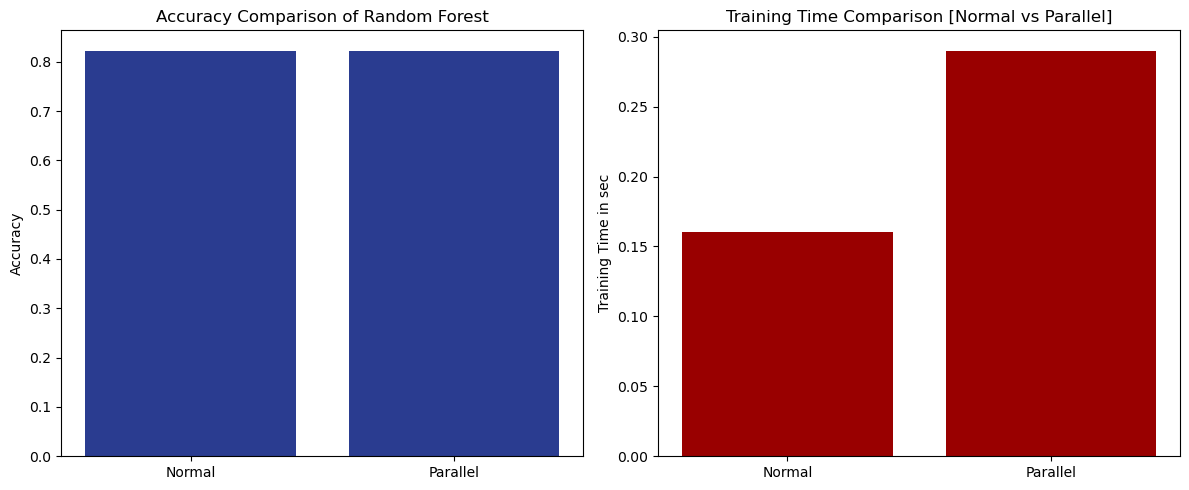

In [16]:
# STEP 5: Visualize Accuracy vs Time
labels = ['Normal', 'Parallel']
accuracy = [
    accuracy_score(y_test, y_pred_normal),
    accuracy_score(y_test, y_pred_parallel)
]
training_time = [
    round(end_normal - start_normal, 2),
    round(end_parallel - start_parallel, 2)
]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, accuracy, color='#2a3c90')
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Random Forest")

plt.subplot(1, 2, 2)
plt.bar(labels, training_time, color='#990000')
plt.ylabel("Training Time in sec")
plt.title("Training Time Comparison [Normal vs Parallel]")

plt.tight_layout()
plt.show()